# Effects of taVNS on HRV 
## Discription
2 groups (true label temporally unknown, each patient received VNS for several days during which there were 2 sessions of stimulation). Subject ID from 2020004 to 2020015.

**Warning**: Both the number of days and the number of sessions depend on the subject.
## Objective
- To see the Effects of taVNS on HRV
- Unsupervised clustering to see whether we can distinguise the two groups.

## Input
- nn_interval file (.pickle) for each subject
- info csv (stimulation_timestamped.csv) indicating when the stimulation begins 
**Warning**: the info file was automatically generated. It needs a second check.

## Output
- For each group (patient), we explore the effect of VNS on HRV (boxplot, pre/during/post-stim)
- Taking day as a variable, then we have two independent variable: day and session
- clustering including Features engineering (e.g. $HRV_{during} - \frac{HRV_{pre} + HRV_{post}}{2})$ per patient) and unsupervised learning (e.g. kmeans, DBSCAN)

## Workflow
### 1. double check df_info
- the length of the stimulation should be 20 min
- there should be two stimulations per patient in a single day
### 2. exctract pre/during/post nn_interval and hrv

## Notes:
mising data of 2020006!

## data loading

In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import datetime

data_dir = os.path.expanduser("~/Desktop/GT/ECG_VNS/data")
# os.path.exists(data_dir)  # test

info_filename = os.path.join(data_dir, 'stimulation_timestamped.csv')
df_info = pd.read_csv(info_filename, index_col=0)

## filter bad rows in df_info (drop rows)
### Untackled problem:
- in this version, data were discarded if multipul plausible stimulation onsets were found
### improvement 2 implement:
- loops for list creation and concatenation

In [2]:
# raw by raw scanning
# criteria: 20 min duration
# timestamp format: 2/22/21 20:18
tolerence = 100 # 100 seconds
VNS_duration = 1200 # 1200 seconds

list_subj2filtered_df = []
list_date2filtered_df = []
list_time_s2filtered_df = []
list_switch2filtered_df = []  # 1 stands for on, 0 stands for off

array_subjs = df_info['subject'].unique()
for subj in array_subjs:
    df_per_subj = df_info[df_info['subject'] == subj]
    list_date = []
    list_time_s = []
    for index, row in df_per_subj.iterrows():
        # month/day/year
#         date = row['timestamp'].split('/')[0] + '/' + row['timestamp'].split('/')[1] + row['timestamp'].split('/')[2]
        date = row['timestamp'].split(' ')[0] 
        time = row['timestamp'].split('/')[2].split(' ')[1]
        hour = int(time.split(':')[0])
        minute = int(time.split(':')[1])
        time_s = datetime.timedelta(hours=hour, minutes=minute).total_seconds()
        list_date.append(date)
        list_time_s.append(time_s)
    list_time_s = np.array(list_time_s)
    list_date = np.array(list_date)
    _, unique_indices = np.unique(list_time_s, return_index=True)
    unique_indices = np.sort(unique_indices)
    # make sure that there are either 2 or 4 stim each day
    list_time_s = list_time_s[unique_indices]
    list_date = list_date[unique_indices]
    
    list_time_s_updated = []
    list_date_updated = []
    for date in np.unique(list_date):
        indices2search = np.where(list_date == date)[0]
        find_stim_onset = False
        num_stim_found = 0
        for i in indices2search:
            for j in indices2search[np.where(indices2search == i)[0][0] + 1:]:
                if (VNS_duration - tolerence) < (list_time_s[j] - list_time_s[i]) < (VNS_duration + tolerence):
                    list_time_s_updated.append(list_time_s[i])
                    list_time_s_updated.append(list_time_s[j])
                    find_stim_onset = True
                    num_stim_found +=1
        
                        
        if num_stim_found > 2:  # more than two stim onsets were found
#             list_date_updated = list_date_updated[list_date_updated != date]
            list_time_s_updated = list_time_s_updated[:-2 * num_stim_found]
        else:
            for i in range(num_stim_found):
                list_date_updated.append(date)
    list_subj2filtered_df = list_subj2filtered_df + [subj] * len(list_time_s_updated)
    list_date2filtered_df = list_date2filtered_df + [date for date in list_date_updated for _ in (0, 1)]
    list_time_s2filtered_df = list_time_s2filtered_df + list_time_s_updated
    list_switch2filtered_df = list_switch2filtered_df + [i for j in range(len(list_date_updated)) for i in [1, 0] ]

# we create new df from arrays here
df_info_filtered = pd.DataFrame(data=np.array([np.array(list_subj2filtered_df), np.array(list_date2filtered_df),
                                               np.array(list_time_s2filtered_df), 
                                      np.array(list_switch2filtered_df)]).T,
                                    columns=['subj', 'date', 'time_s', 'switch'])
df_info_filtered.to_csv(os.path.join(data_dir, 'stimulation_timestamped_filtered.csv'))
# Test properties here via assert. This applies when 

In [3]:
# Let's see how it looks like
# load the csv if necessary
df_info_filtered.head(12)

,subj,date,time_s,switch
0,2020004,2/22/21,73080.0,1
1,2020004,2/22/21,74340.0,0
2,2020004,2/23/21,75780.0,1
3,2020004,2/23/21,77040.0,0
4,2020004,2/24/21,27300.0,1
5,2020004,2/24/21,28560.0,0
6,2020004,2/24/21,71700.0,1
7,2020004,2/24/21,72960.0,0
8,2020004,2/25/21,31800.0,1
9,2020004,2/25/21,33060.0,0


## extract pre/during/post-stm from pickle files
Output format:

| subj  | date | time |    session      | nn_interval|
| ----- | ---- | ---- | --------------- | ---------- |
|2020014| 2/23 |am/pm | pre/during/post |    value   |

**Be careful, this might take 8h on mac**

In [81]:
noon_s = 12*60*60
def am_or_pm(time_s):
    if 0 < time_s < noon_s:
        output = 'am'
    else:
        output = 'pm'
    return output

def datetime2time_s(datetime_series):
    '''
    datetime is a pd series, no vectorized operation is possible
    '''
    time_s = []
    for i in datetime_series:
        hours = i.hour
        minutes = i.minute
        seconds = i.second
        time_s.append(datetime.timedelta(hours=hours, minutes=minutes, 
                                seconds=seconds).total_seconds())
    return time_s

subj2df = []
date2df = []
time2df = []
session2df = []
nn_interval2df = []
for subj_id in array_subjs:
    nn_filename = os.path.join(data_dir, str(subj_id) + '.pickle')
    df = pd.read_pickle(nn_filename)
#     # truncate to speed up
#     df = df.truncate(before=175000, after= 176000)
#     # reindex by time_s
#     df['time_s_idx'] = datetime2time_s(df['timestamp'])
#     df.set_index('time_s_idx')
    df_info_per_subj = df_info_filtered[df_info_filtered['subj'] == str(subj_id)]
    dates = pd.unique(df_info_per_subj['date'])
    df_info_per_subj_day = df_info_per_subj[df_info_per_subj['date'] == date]
    
    for index, row in df.iterrows():
        # date conversion
        date = row['timestamp'].strftime('%-m/%d/%y')
        time_s = datetime.timedelta(hours=row['timestamp'].hour, minutes=row['timestamp'].minute, 
                            seconds = row['timestamp'].second).total_seconds()
        
        df_info_per_subj_day = df_info_per_subj[df_info_per_subj['date'] == date]
        onset_pre_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '1'].reset_index()['time_s'].astype(float)\
        - VNS_duration
        offset_pre_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '1'].reset_index()['time_s'].astype(float)

        onset_post_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '0'].reset_index()['time_s'].astype(float)
        offset_post_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '0'].reset_index()['time_s'].astype(float)\
        + VNS_duration
        time = am_or_pm(time_s)
        
        for i in range(int(df_info_per_subj_day.shape[0]/2)):  # we have one stim in the morning, one in the afternoon
            if onset_pre_VNS[i] < time_s < offset_pre_VNS[i]:
                date2df.append(date)
                session2df.append('pre')
                time2df.append(time)
                nn_interval2df.append(row['nn_interval'])
                subj2df.append(subj_id)
            elif offset_pre_VNS[i] < time_s < onset_post_VNS[i]:
                date2df.append(date)
                session2df.append('during')
                time2df.append(time)
                nn_interval2df.append(row['nn_interval'])
                subj2df.append(subj_id)
            elif onset_post_VNS[i] < time_s < offset_post_VNS[i]:
                date2df.append(date)
                session2df.append('post')
                time2df.append(time)
                nn_interval2df.append(row['nn_interval'])
                subj2df.append(subj_id)
            else:
                continue
df_filtered = pd.DataFrame(data=np.array([np.array(subj2df), np.array(date2df),np.array(time2df), np.array(session2df),
                                          np.array(nn_interval2df)]).T,
                                    columns=['subj', 'date', 'time', 'session', 'nn_interval'])
df_filtered.to_csv(os.path.join(data_dir, 'nn_interval_whole.csv'))                

## feature extraction from nn_interval 
The output would have a set of features per patient per date per time per session, we label the patient based on assigner, and integrate subj, date, and time to create a new id

- mean_nni: The mean of RR-intervals.
- sdnn : The standard deviation of the time interval between successive normal heart beats (i.e. the RR-intervals).
- sdsd: The standard deviation of differences between adjacent RR-intervals
- rmssd: The square root of the mean of the sum of the squares of differences between adjacent NN-intervals. Reflects high frequency (fast or parasympathetic) influences on hrV (i.e., those influencing larger changes from one beat to the next).
- median_nni: Median Absolute values of the successive differences between the RR-intervals.
- nni_50: Number of interval differences of successive RR-intervals greater than 50 ms.
- pnni_50: The proportion derived by dividing nni_50 (The number of interval differences of successive RR-intervals greater than 50 ms) by the total number of RR-intervals.
- nni_20: Number of interval differences of successive RR-intervals greater than 20 ms.
- pnni_20: The proportion derived by dividing nni_20 (The number of interval differences of successive RR-intervals greater than 20 ms) by the total number of RR-intervals.
- range_nni: difference between the maximum and minimum nn_interval.
- cvsd: Coefficient of variation of successive differences equal to the rmssd divided by mean_nni.
- cvnni: Coefficient of variation equal to the ratio of sdnn divided by mean_nni.
- mean_hr: The mean Heart Rate.
- max_hr: Max heart rate.
- min_hr: Min heart rate.
- std_hr: Standard deviation of heart rate.

In [52]:
# load df_filtered if you start from this cell
import os
import pandas as pd
from hrvanalysis import get_time_domain_features
from hrvanalysis import get_geometrical_features
from hrvanalysis import get_frequency_domain_features
data2df_hrv = []
df_filtered = pd.read_csv(os.path.join(data_dir, 'nn_interval_whole.csv'),index_col=0)
for subj in pd.unique(df_filtered['subj']):
    df_filtered_temp = df_filtered[df_filtered['subj']==subj]  # temporary df to retrieve stim dates for a subject  
    for date in pd.unique(df_filtered_temp['date']):
        df_filtered_temp = df_filtered[(df_filtered['subj']==subj) & (df_filtered['date']==date)]        
        for time in pd.unique(df_filtered_temp['time']):
            df_filtered_temp = df_filtered[(df_filtered['subj']==subj) & (df_filtered['date']==date) &\
            (df_filtered['time']==time)]
            for session in pd.unique(df_filtered_temp['session']):
                data2calculate_hrv = df_filtered[(df_filtered['subj']==subj) & (df_filtered['date']==date) &\
                                                 (df_filtered['time']==time) & (df_filtered['session']==session)]
                time_domain_features = get_time_domain_features(data2calculate_hrv['nn_interval'].astype(float))
                frequency_domain_features = get_frequency_domain_features(data2calculate_hrv['nn_interval'].astype(float))
                data2df_hrv.append([subj, date, time, session] + list(time_domain_features.values()) +\
                                   list(frequency_domain_features.values()))

df_hrv = pd.DataFrame(data2df_hrv, columns=['subj', 'date', 'time', 'session'] + list(time_domain_features.keys()) +
                      list(frequency_domain_features.keys()))
df_assignment = pd.read_excel(os.path.join(data_dir, 'Treatment Group Assigner.xlsx'))
df_assignment = df_assignment.dropna()
df_assignment['Parent Study ID Number'] = df_assignment['Parent Study ID Number'].astype(int)
# df_hrv.head()
# df_assignment.head()
group = []
subj_date_time_col = []
for index, row in df_hrv.iterrows():
    subj = row['subj']
    group_num = df_assignment[df_assignment['Parent Study ID Number'] == subj]['Treatment Assignment (0= Sham, 1= Stim)'].values[0]
    subj_date_time = str(subj) + str(row['date']) + row['time']
    subj_date_time_col.append(subj_date_time)
    if group_num == 0:
        group.append('Sham')
    elif group_num == 1:
        group.append('Stim')
    else:
        print('undefined group')  # use assert!

# add and reorder the 'group' col        
df_hrv['group'] = group
df_hrv['subj_date_time'] = subj_date_time_col
df_hrv_cols = df_hrv.columns.to_list()
df_hrv_cols_adjusted = df_hrv_cols[:4] + df_hrv_cols[(len(df_hrv_cols)-2):] + df_hrv_cols[4:len(df_hrv_cols)-2]
df_hrv= df_hrv[df_hrv_cols_adjusted]
df_hrv.to_csv(os.path.join(data_dir, 'hrv_features.csv'))

/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 241, using nperseg = 241
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 99, using nperseg = 99
  warnings.warn('nperseg = {0:d} is greater than input length '


In [56]:
# a glimpse of df_hrv
import os
import pandas as pd
data_dir = os.path.expanduser("~/Desktop/GT/ECG_VNS/data")
df_hrv = pd.read_csv(os.path.join(data_dir, 'hrv_features.csv'), index_col=0)
print(df_hrv.columns)
df_hrv.head()

Index(['subj', 'date', 'time', 'session', 'group', 'subj_date_time',
       'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20',
       'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr',
       'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu',
       'total_power', 'vlf'],
      dtype='object')


,subj,date,time,session,group,subj_date_time,mean_nni,sdnn,sdsd,nni_50,...,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf
0,2020004,2/22/21,pm,pre,Stim,20200042/22/21pm,789.000996,167.557260,120.383358,943,...,197.368421,46.296296,20.272745,11924.646500,6413.144781,1.859407,65.027714,34.972286,21759.491356,3421.700075
1,2020004,2/22/21,pm,during,Stim,20200042/22/21pm,737.067052,150.376417,111.370384,1048,...,198.675497,43.541364,21.000451,7225.438826,5839.264420,1.237389,55.305036,44.694964,15088.263391,2023.560145
2,2020004,2/22/21,pm,post,Stim,20200042/22/21pm,756.520625,170.644339,128.062885,1001,...,194.805195,41.039672,21.957764,11085.624029,7277.078798,1.523362,60.370329,39.629671,21938.746889,3576.044063
3,2020004,2/23/21,pm,pre,Stim,20200042/23/21pm,578.139241,81.546339,68.332912,191,...,197.368421,83.798883,18.717590,1289.116812,1985.488719,0.649269,39.367087,60.632913,4179.199720,904.594189
4,2020004,2/23/21,pm,during,Stim,20200042/23/21pm,567.039251,78.103561,65.691908,1038,...,197.368421,46.153846,17.043396,1732.387759,1864.828001,0.928980,48.159128,51.840872,4202.458487,605.242728


## statistic analysis and visualization
According to preliminay results from SPSS, hrv is heteogeneous.

- paired-sample t test for each patient. Significant results are: nni_20: Number of interval differences of successive RR-intervals greater than 20 ms

In [58]:
import pingouin as pg
for hrv_metric in df_hrv.columns[6:]:
    aov = pg.mixed_anova(data=df_hrv, dv=hrv_metric, within='session', subject='subj', between='group')
    print(hrv_metric)
    pg.print_table(aov)

mean_nni

ANOVA SUMMARY

Source              SS    DF1    DF2         MS      F    p-unc    np2      eps
-----------  ---------  -----  -----  ---------  -----  -------  -----  -------
group        83063.570      1      8  83063.570  1.403    0.270  0.149  nan
session       1742.237      2     16    871.118  1.857    0.188  0.188    0.677
Interaction    725.897      2     16    362.949  0.774    0.478  0.088  nan

sdnn

ANOVA SUMMARY

Source              SS    DF1    DF2         MS      F    p-unc    np2      eps
-----------  ---------  -----  -----  ---------  -----  -------  -----  -------
group        14611.401      1      8  14611.401  0.879    0.376  0.099  nan
session         71.154      2     16     35.577  0.104    0.902  0.013    0.713
Interaction     61.817      2     16     30.908  0.091    0.914  0.011  nan

sdsd

ANOVA SUMMARY

Source             SS    DF1    DF2        MS      F    p-unc    np2      eps
-----------  --------  -----  -----  --------  -----  -------  ----- 

/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pingouin/distribution.py:950: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d


cvsd

ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
group        0.005      1      8  0.005  0.501    0.499  0.059  nan
session      0.000      2     16  0.000  0.279    0.760  0.034    0.687
Interaction  0.000      2     16  0.000  0.981    0.397  0.109  nan

cvnni

ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
group        0.010      1      8  0.010  0.525    0.489  0.062  nan
session      0.000      2     16  0.000  0.307    0.740  0.037    0.771
Interaction  0.000      2     16  0.000  0.380    0.690  0.045  nan

mean_hr

ANOVA SUMMARY

Source            SS    DF1    DF2       MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  -------  -----  -------  -----------  -----  -------  ------------

In [28]:
pg.pairwise_ttests(dv='range_nni', within='session', subject='subj', between='group', data=df_hrv)

,Contrast,session,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,session,-,during,post,True,True,-1.904119,9.000000,two-sided,0.089298,1.146,-0.275082
1,session,-,during,pre,True,True,-0.275969,9.000000,two-sided,0.788804,0.319,-0.021823
2,session,-,post,pre,True,True,2.700064,9.000000,two-sided,0.024391,3.061,0.254450
3,group,-,Sham,Stim,False,True,1.059568,5.052477,two-sided,0.337344,0.693,0.664497
4,session * group,during,Sham,Stim,False,True,1.126092,9.244847,two-sided,0.288509,0.572,0.471393
5,session * group,post,Sham,Stim,False,True,1.399984,9.012769,two-sided,0.194987,0.738,0.612297
6,session * group,pre,Sham,Stim,False,True,1.590606,9.089412,two-sided,0.145830,0.908,0.687466


<AxesSubplot:title={'center':'sham group'}, xlabel='session', ylabel='range_nni'>

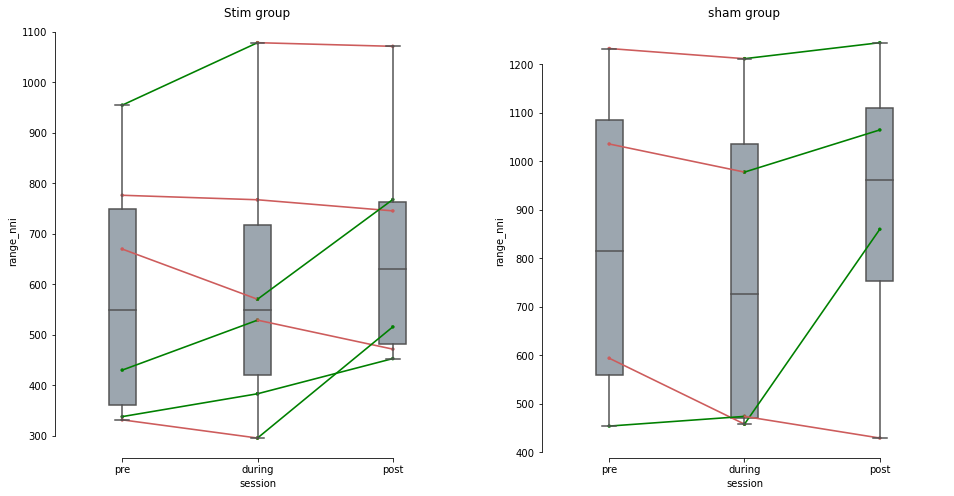

In [72]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes[0].set_title('Stim group')
axes[1].set_title('sham group')
pg.plot_paired(data=df_hrv[df_hrv['group']=='Stim'], dv='range_nni', within='session', subject='subj', dpi=150, ax=axes[0], order=['pre', 'during', 'post'])
pg.plot_paired(data=df_hrv[df_hrv['group']=='Sham'], dv='range_nni', within='session', subject='subj', dpi=150, ax=axes[1], order=['pre', 'during', 'post'])

## use subj_date_time as id

In [70]:
# check whether pre, during, post data exist for each id
df_hrv_sdtID = df_hrv.copy()
indices2drop = []
for index, row in df_hrv_sdtID.iterrows():
    sdt_id = row['subj_date_time']
    if df_hrv_sdtID[df_hrv_sdtID['subj_date_time'] == sdt_id].shape[0] < 3:
        indices2drop.append(index)
df_hrv_sdtID = df_hrv_sdtID.drop(indices2drop)

import pingouin as pg
for hrv_metric in df_hrv.columns[6:]:
    aov = pg.mixed_anova(data=df_hrv, dv=hrv_metric, within='session', subject='subj_date_time', between='group')
    print(hrv_metric)
    pg.print_table(aov)

mean_nni

ANOVA SUMMARY

Source               SS    DF1    DF2          MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ----------  -----  -----  ----------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
group        351911.812      1     46  351911.812  7.778    0.008      nan      0.145  nan           nan        nan        nan
session        2647.307      2     92    1323.653  1.413    0.249        0.246  0.030    0.858         0.000      0.835      0.019
Interaction    1121.221      2     92     560.611  0.599    0.552      nan      0.013  nan           nan        nan        nan

sdnn

ANOVA SUMMARY

Source              SS    DF1    DF2         MS      F    p-unc    np2      eps
-----------  ---------  -----  -----  ---------  -----  -------  -----  -------
group        37925.126      1     46  37925.126  3.507    0.067  0.071  nan
session        201.738      2     92    100.869  0.288    0.750  0.006

/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pingouin/distribution.py:950: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d


cvsd

ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
group        0.005      1     46  0.005  0.699    0.407  0.015  nan
session      0.000      2     92  0.000  0.201    0.819  0.004    0.929
Interaction  0.001      2     92  0.000  1.266    0.287  0.027  nan

cvnni

ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
group        0.018      1     46  0.018  1.276    0.265  0.027  nan
session      0.000      2     92  0.000  0.117    0.890  0.003    0.984
Interaction  0.001      2     92  0.000  0.570    0.568  0.012  nan

mean_hr

ANOVA SUMMARY

Source             SS    DF1    DF2        MS      F    p-unc    np2      eps
-----------  --------  -----  -----  --------  -----  -------  -----  -------
group        2969.245      1     46  2969.245  5.577    0.022  0.108  n

## Plot for session/interaction effect

<AxesSubplot:title={'center':'sham group'}, xlabel='session', ylabel='mean_hr'>

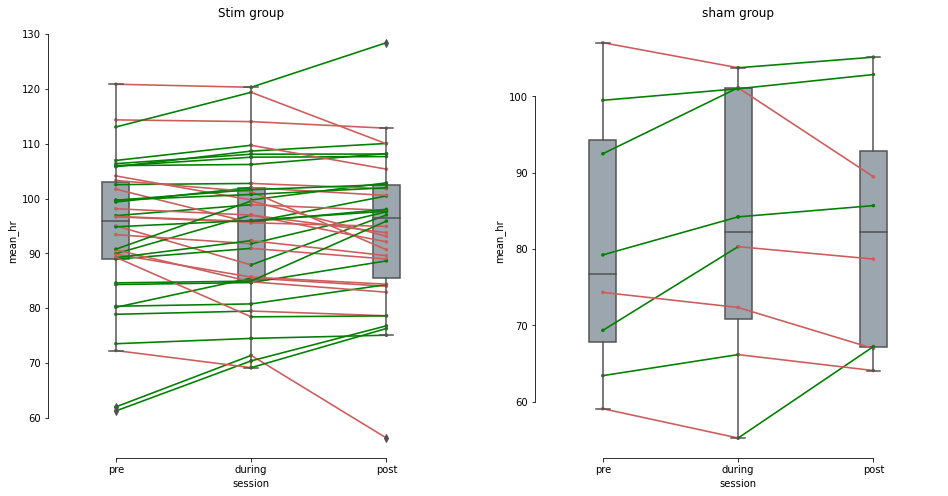

In [83]:
# eliminate confound factor - time
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes[0].set_title('Stim group')
axes[1].set_title('sham group')
pg.plot_paired(data=df_hrv_sdtID[df_hrv_sdtID['group']=='Stim'], dv='mean_hr', within='session', subject='subj_date_time', dpi=150, ax=axes[0], order=['pre', 'during', 'post'])
pg.plot_paired(data=df_hrv_sdtID[df_hrv_sdtID['group']=='Sham'], dv='mean_hr', within='session', subject='subj_date_time', dpi=150, ax=axes[1], order=['pre', 'during', 'post'])

## plot for only group effect

<Figure size 720x576 with 0 Axes>

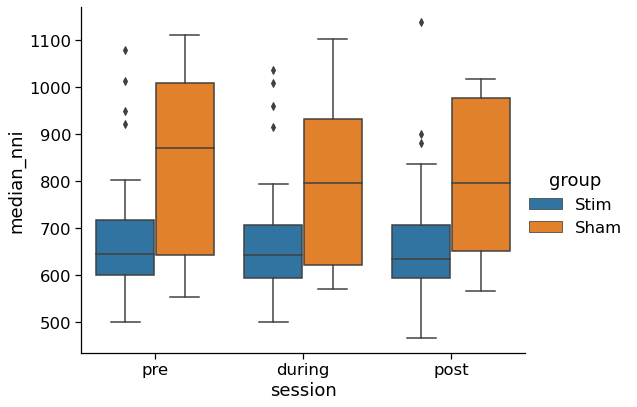

In [86]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(10,8))
sns.catplot(x='session', 
            y='median_nni',
            hue="group",
            kind="box",
            data=df_hrv_sdtID, 
            height=6, 
            aspect=1.3);

In [89]:
# combine subj-date-time
pg.pairwise_ttests(dv='vlf', within='session', subject='subj_date_time', between='group', data=df_hrv_sdtID)

,Contrast,session,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,session,-,during,post,True,True,0.927138,45.000000,two-sided,0.358801,0.24,0.048061
1,session,-,during,pre,True,True,0.901107,45.000000,two-sided,0.372329,0.234,0.076439
2,session,-,post,pre,True,True,0.251476,45.000000,two-sided,0.802591,0.165,0.022671
3,group,-,Sham,Stim,False,True,1.333898,7.249155,two-sided,0.222620,0.691,0.975696
4,session * group,during,Sham,Stim,False,True,1.360581,7.269489,two-sided,0.214325,0.71,0.983744
5,session * group,post,Sham,Stim,False,True,1.199954,7.201494,two-sided,0.268140,0.611,0.903063
6,session * group,pre,Sham,Stim,False,True,1.365943,7.423477,two-sided,0.211898,0.714,0.912792
